In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms import v2

In [2]:
# Define a custom dataset for Fashion MNIST
class FashionMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = self.transform(x)

        return x, y

In [3]:
# Set up data transforms
#transform = transforms.Compose([transforms.Grayscale(num_output_channels=3), transforms.ToTensor()])

# Random Erasing
transform = transforms.Compose([transforms.Grayscale(num_output_channels=3), transforms.ToTensor(),transforms.RandomErasing(p=0.5)])

# Load the Fashion MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

cutmix = v2.CutMix(num_classes=10)
mixup = v2.MixUp(num_classes=10)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

In [4]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)  # Change the number of input channels to 3
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 64 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
# Initialize the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# Training and testing loop for losses and accuracy
num_epochs = 10

train_losses = []  # List to store training losses
test_losses = []   # List to store test losses
train_accuracies = []  # List to store training accuracies
test_accuracies = []  # List to store test accuracies

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        
        # Apply either CutMix or MixUp
        #data, target = mixup(inputs, labels)
        # Apply either CutMix or MixUp
        #data, target = cutmix(inputs, labels)
        # Apply either CutMix or MixUp
        #data, target = cutmix_or_mixup(inputs, labels)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct_predictions / total_samples)

    model.eval()
    correct_predictions = 0
    total_samples = 0
    test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = correct_predictions / total_samples
    test_accuracies.append(accuracy)
    test_losses.append(test_loss / len(test_loader))

    print(f'Epoch {epoch + 1}, Training Loss: {train_losses[-1]}, Training Accuracy: {100 * train_accuracies[-1]:.2f}%, Test Loss: {test_losses[-1]}, Test Accuracy: {100 * accuracy:.2f}%')

print("Training and Testing Finished.")

Epoch 1, Training Loss: 0.6779339373238814, Training Accuracy: 75.02%, Test Loss: 0.4977426200727873, Test Accuracy: 81.70%
Epoch 2, Training Loss: 0.4435389845737262, Training Accuracy: 83.92%, Test Loss: 0.41504602341712277, Test Accuracy: 84.83%
Epoch 3, Training Loss: 0.3846376750832682, Training Accuracy: 85.84%, Test Loss: 0.3905834659368177, Test Accuracy: 85.93%
Epoch 4, Training Loss: 0.34597938515738386, Training Accuracy: 87.41%, Test Loss: 0.35681202045724364, Test Accuracy: 86.87%
Epoch 5, Training Loss: 0.3179884764558471, Training Accuracy: 88.38%, Test Loss: 0.33505222107036203, Test Accuracy: 87.69%
Epoch 6, Training Loss: 0.29935165041926576, Training Accuracy: 88.90%, Test Loss: 0.31868908073328717, Test Accuracy: 88.39%
Epoch 7, Training Loss: 0.2824305198403564, Training Accuracy: 89.67%, Test Loss: 0.3147304059018063, Test Accuracy: 88.16%
Epoch 8, Training Loss: 0.26716820099778266, Training Accuracy: 89.99%, Test Loss: 0.32145088364051866, Test Accuracy: 88.16%


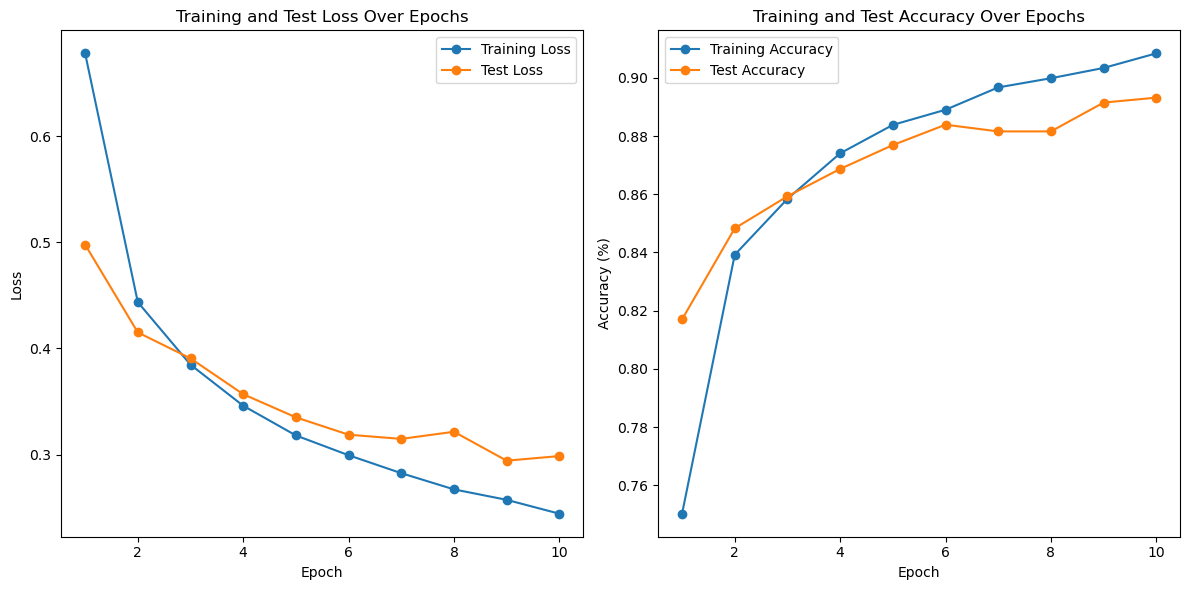

In [7]:
# Plot training and test losses and accuracies
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.plot(range(1, num_epochs + 1), test_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Test Loss'])
plt.title('Training and Test Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o')
plt.plot(range(1, num_epochs + 1), test_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.title('Training and Test Accuracy Over Epochs')

plt.tight_layout()
plt.show()